# Credit Card Dataset Clustering Using R

### Author: Arash Sadeghzadeh

Data for this notebook can be retrieved from the following URL:

https://www.kaggle.com/datasets/arjunbhasin2013/ccdata


For this dataset clustering methods have already been explored using **python** at the following repository:

https://github.com/AraSadz/Exploring-Clustering-Methods-Using-Credit-Card-Dataset

In this notebook we explore  clustering of the credit card dataset available on kaggle. After initially exploring the dataset to get familiar with the data, we will carry out data cleaning to prepare the data for the clustering task. Handling skewness, deleting outliers, handling null values and duplicate values are amongst the actions that we will perform to clean our data. Afterwards, we consider the clustering problem. K Mean, Agglomerative Hierarchical are applied on our data. 

In [51]:
library(dplyr)
library(ggplot2)
library(factoextra)
library(cluster)
library(reshape)
library(repr)
library(RColorBrewer)
library(MASS)
library(gridExtra)
library(Rtsne)
library(moments)

Let's set the seed to ensure the reproducibility of the results:

In [2]:
set.seed(90)

Now, we load the data:

In [3]:
 df <- read.csv("./CC GENERAL.csv")
head(df)

CUST_ID BALANCE    BALANCE_FREQUENCY PURCHASES ONEOFF_PURCHASES
1 C10001    40.90075 0.818182            95.40      0.00         
2 C10002  3202.46742 0.909091             0.00      0.00         
3 C10003  2495.14886 1.000000           773.17    773.17         
4 C10004  1666.67054 0.636364          1499.00   1499.00         
5 C10005   817.71434 1.000000            16.00     16.00         
6 C10006  1809.82875 1.000000          1333.28      0.00         
  INSTALLMENTS_PURCHASES CASH_ADVANCE PURCHASES_FREQUENCY
1   95.40                   0.000     0.166667           
2    0.00                6442.945     0.000000           
3    0.00                   0.000     1.000000           
4    0.00                 205.788     0.083333           
5    0.00                   0.000     0.083333           
6 1333.28                   0.000     0.666667           
  ONEOFF_PURCHASES_FREQUENCY PURCHASES_INSTALLMENTS_FREQUENCY
1 0.000000                   0.083333                        
2 0.000000                   0.000000                        
3 1.000000                   0.000000                        
4 0.083333                   0.000000                        
5 0.083333                   0.000000                        
6 0.000000                   0.583333                        
  CASH_ADVANCE_FREQUENCY CASH_ADVANCE_TRX PURCHASES_TRX CREDIT_LIMIT PAYMENTS 
1 0.000000               0                 2            1000          201.8021
2 0.250000               4                 0            7000         4103.0326
3 0.000000               0                12            7500          622.0667
4 0.083333               1                 1            7500            0.0000
5 0.000000               0                 1            1200          678.3348
6 0.000000               0                 8            1800         1400.0578
  MINIMUM_PAYMENTS PRC_FULL_PAYMENT TENURE
1  139.5098        0.000000         12    
2 1072.3402        0.222222         12    
3  627.2848        0.000000         12    
4        NA        0.000000         12    
5  244.7912        0.000000         12    
6 2407.2460        0.000000         12

One can see that the dataset has 18 features with about 9000 observations:

In [4]:
dim(df)

[1] 8950   18

Now, let's display the contents of our data frame:

In [5]:
str(df)

'data.frame':	8950 obs. of  18 variables:
 $ CUST_ID                         : chr  "C10001" "C10002" "C10003" "C10004" ...
 $ BALANCE                         : num  40.9 3202.5 2495.1 1666.7 817.7 ...
 $ BALANCE_FREQUENCY               : num  0.818 0.909 1 0.636 1 ...
 $ PURCHASES                       : num  95.4 0 773.2 1499 16 ...
 $ ONEOFF_PURCHASES                : num  0 0 773 1499 16 ...
 $ INSTALLMENTS_PURCHASES          : num  95.4 0 0 0 0 ...
 $ CASH_ADVANCE                    : num  0 6443 0 206 0 ...
 $ PURCHASES_FREQUENCY             : num  0.1667 0 1 0.0833 0.0833 ...
 $ ONEOFF_PURCHASES_FREQUENCY      : num  0 0 1 0.0833 0.0833 ...
 $ PURCHASES_INSTALLMENTS_FREQUENCY: num  0.0833 0 0 0 0 ...
 $ CASH_ADVANCE_FREQUENCY          : num  0 0.25 0 0.0833 0 ...
 $ CASH_ADVANCE_TRX                : int  0 4 0 1 0 0 0 0 0 0 ...
 $ PURCHASES_TRX                   : int  2 0 12 1 1 8 64 12 5 3 ...
 $ CREDIT_LIMIT                    : num  1000 7000 7500 7500 1200 1800 13500 2300 7

Now, we create histogram of all columns in our data frame to evaluate the skewness of our data:

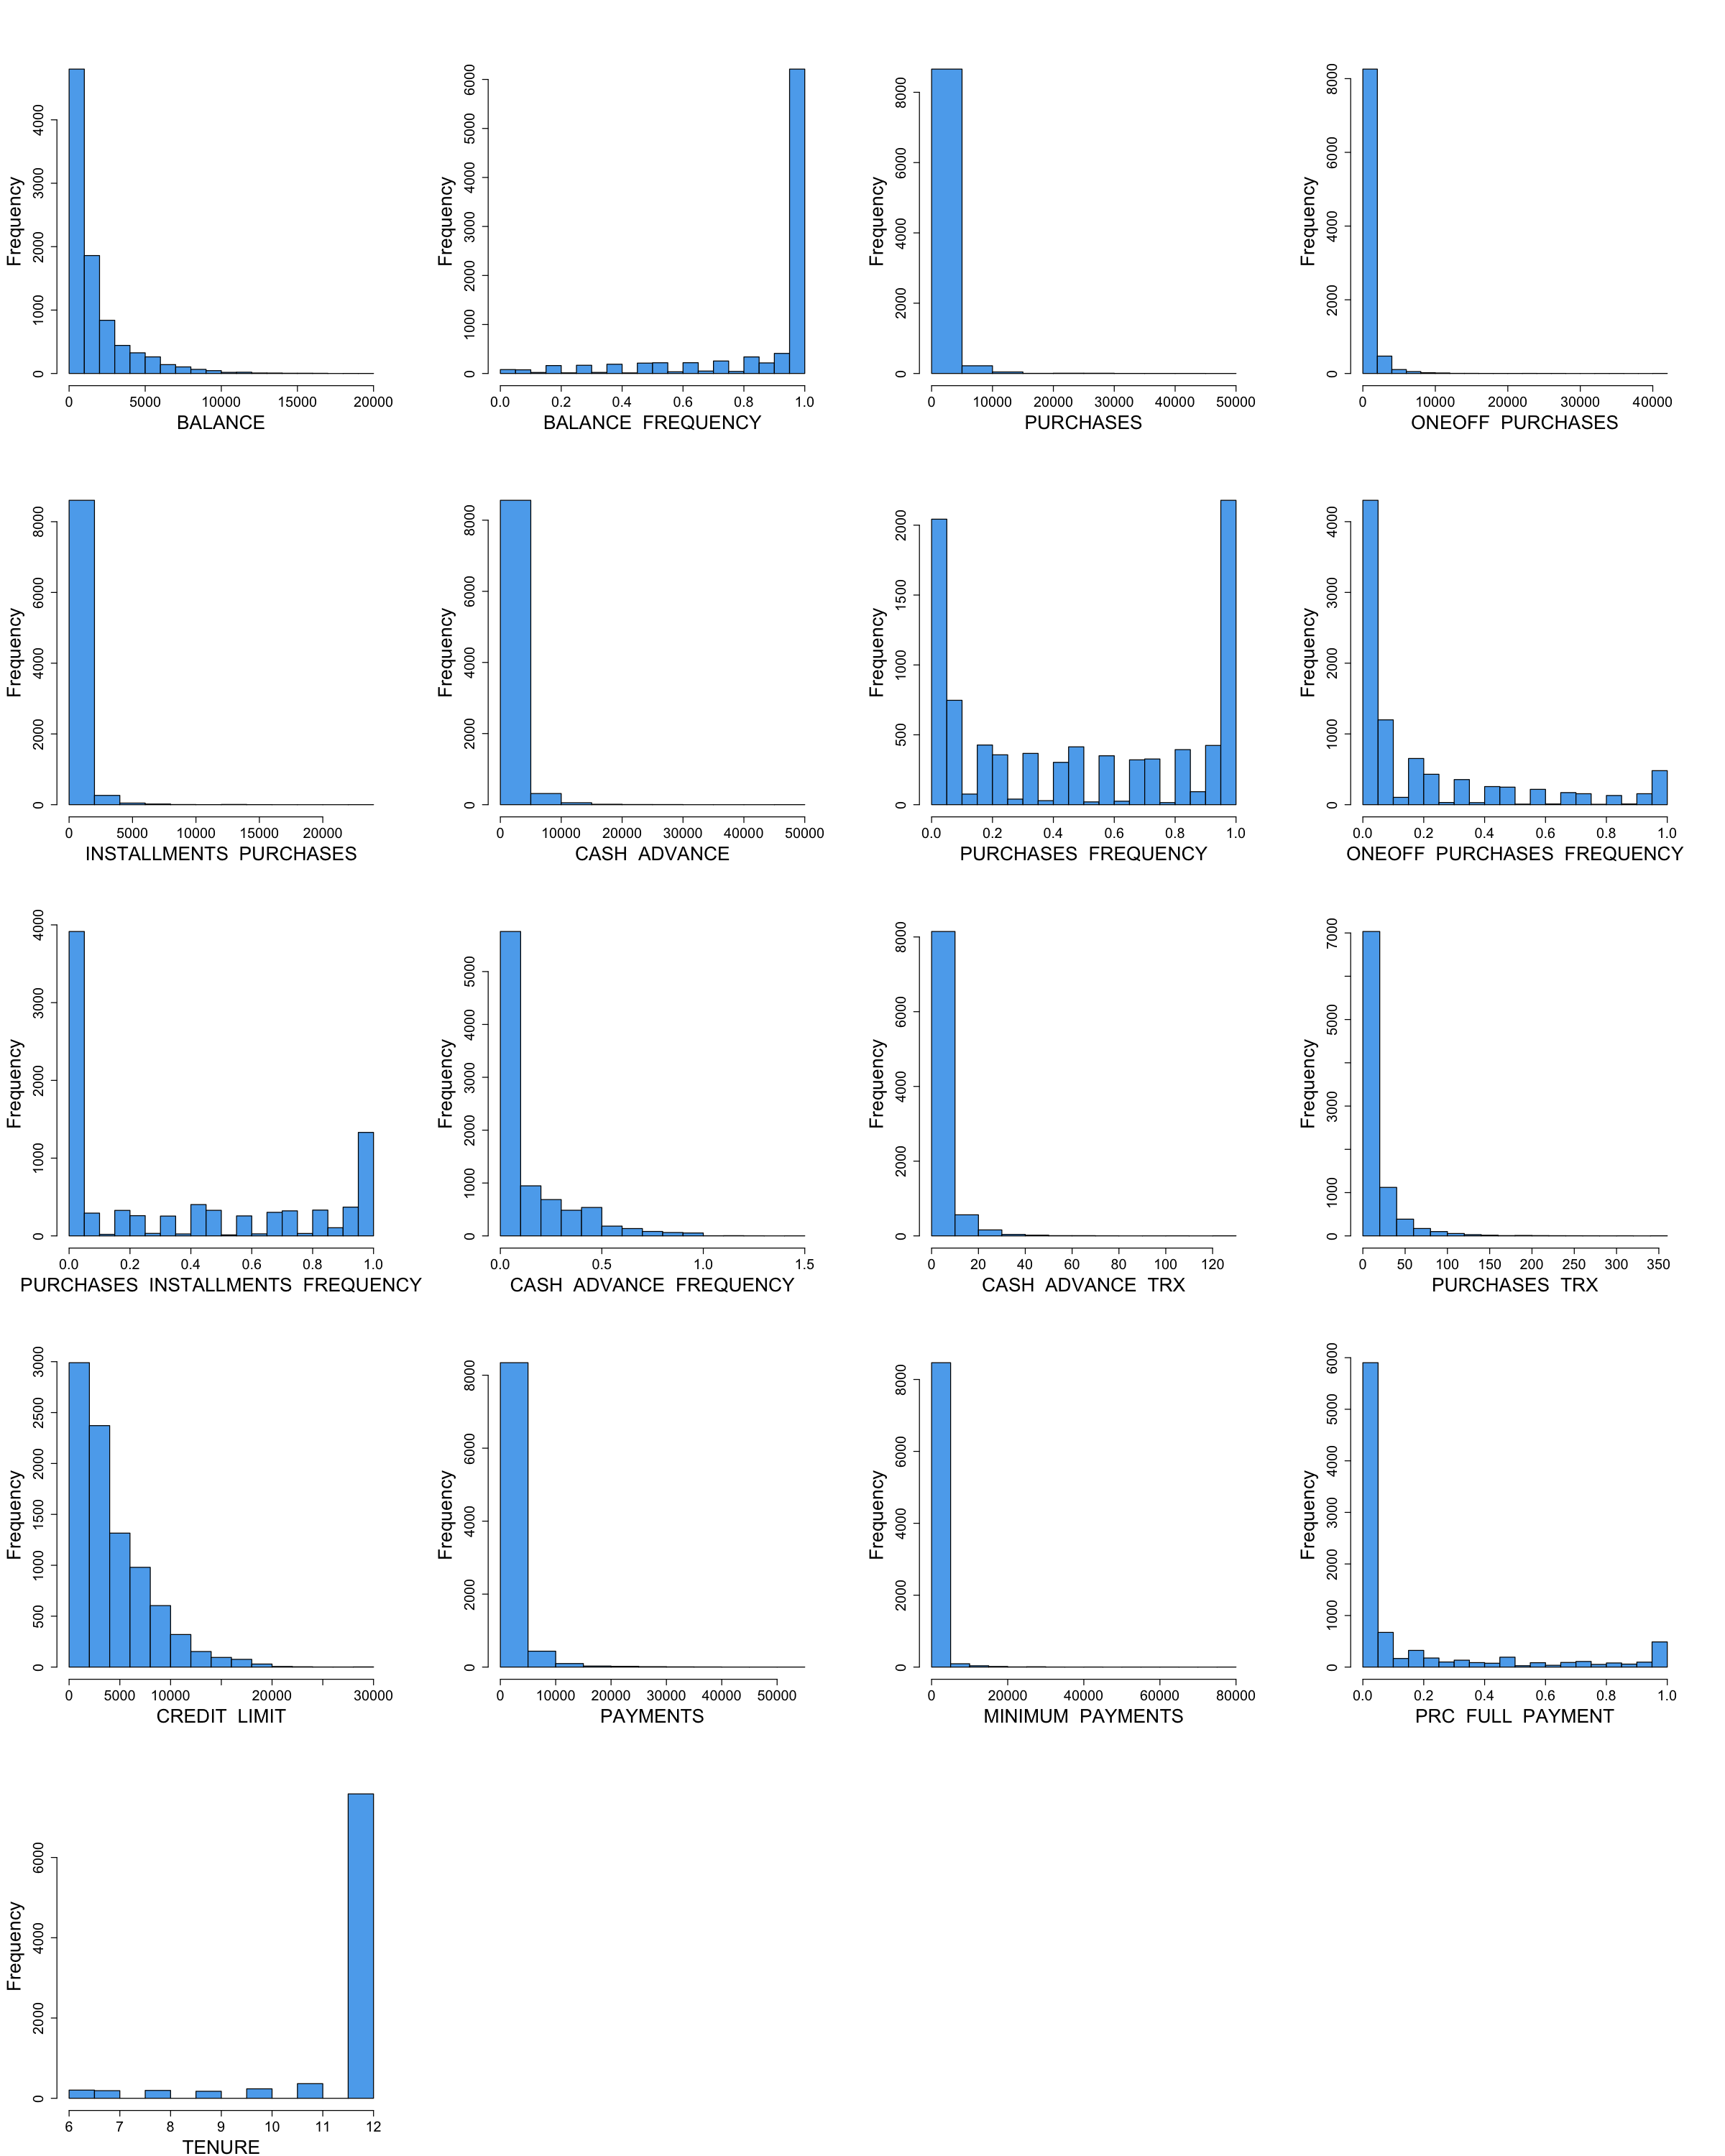

In [6]:
options(repr.plot.width=20, repr.plot.height=25)

par(mfrow=c(5,4), mar=c(4,5,5,4), cex.lab=2, cex.axis=1.5)
for(name in names(df[,-1])) {
   hist(df[[name]], xlab=name, main="", col="Steelblue2")
}

As one can see, the data is highly skewed, We will take care of it later. We can compute the skewness of our data frame as follow. Note that the first column contains the customer ID and we remove it to compute the skewness.

In [7]:
data.frame(skewness=skewness(df[,-1], na.rm=TRUE))

skewness   
BALANCE                           2.39298490
BALANCE_FREQUENCY                -2.02292641
PURCHASES                         8.14290404
ONEOFF_PURCHASES                 10.04339927
INSTALLMENTS_PURCHASES            7.29789654
CASH_ADVANCE                      5.16574312
PURCHASES_FREQUENCY               0.06015415
ONEOFF_PURCHASES_FREQUENCY        1.53535541
PURCHASES_INSTALLMENTS_FREQUENCY  0.50911582
CASH_ADVANCE_FREQUENCY            1.82837977
CASH_ADVANCE_TRX                  5.72033928
PURCHASES_TRX                     4.62987914
CREDIT_LIMIT                      1.52220880
PAYMENTS                          5.90662964
MINIMUM_PAYMENTS                 13.62043099
PRC_FULL_PAYMENT                  1.94249431
TENURE                           -2.94252402

 Obviousely, the data is highly skewed.

Additionally, let's have a look at the number of unique values in each column:

In [8]:
Num_Unique_Values <- apply(df,2, function(x) length(unique(x)))
data.frame(Num_Unique_Values)

Num_Unique_Values
CUST_ID                          8950             
BALANCE                          8871             
BALANCE_FREQUENCY                  43             
PURCHASES                        6203             
ONEOFF_PURCHASES                 4014             
INSTALLMENTS_PURCHASES           4452             
CASH_ADVANCE                     4323             
PURCHASES_FREQUENCY                47             
ONEOFF_PURCHASES_FREQUENCY         47             
PURCHASES_INSTALLMENTS_FREQUENCY   47             
CASH_ADVANCE_FREQUENCY             54             
CASH_ADVANCE_TRX                   65             
PURCHASES_TRX                     173             
CREDIT_LIMIT                      206             
PAYMENTS                         8711             
MINIMUM_PAYMENTS                 8637             
PRC_FULL_PAYMENT                   47             
TENURE                              7

# Duplicates

We need to omit the duplicate values. Let's investigate whether there exist any duplicate values in our data frame:

In [9]:
any(duplicated(df))

[1] FALSE

Fortunately, there exist no duplicate vaues in the data frame.

CUST_ID is not required, so we can delete that column:

In [10]:
df <- subset(df, select = -CUST_ID)
head(df, 3)

BALANCE    BALANCE_FREQUENCY PURCHASES ONEOFF_PURCHASES
1   40.90075 0.818182           95.40      0.00          
2 3202.46742 0.909091            0.00      0.00          
3 2495.14886 1.000000          773.17    773.17          
  INSTALLMENTS_PURCHASES CASH_ADVANCE PURCHASES_FREQUENCY
1 95.4                      0.000     0.166667           
2  0.0                   6442.945     0.000000           
3  0.0                      0.000     1.000000           
  ONEOFF_PURCHASES_FREQUENCY PURCHASES_INSTALLMENTS_FREQUENCY
1 0                          0.083333                        
2 0                          0.000000                        
3 1                          0.000000                        
  CASH_ADVANCE_FREQUENCY CASH_ADVANCE_TRX PURCHASES_TRX CREDIT_LIMIT PAYMENTS 
1 0.00                   0                 2            1000          201.8021
2 0.25                   4                 0            7000         4103.0326
3 0.00                   0                12            7500          622.0667
  MINIMUM_PAYMENTS PRC_FULL_PAYMENT TENURE
1  139.5098        0.000000         12    
2 1072.3402        0.222222         12    
3  627.2848        0.000000         12

## Missing Values

There exist some NA's values in our dataset. Let's see how many observations are free from NA values:

In [11]:
sum(complete.cases(df))

[1] 8636

Now, we can investigate which features contains NA values:

In [12]:
Num_Missing_Values <- apply(df, 2, function(x) sum(is.na(x)))
data.frame(Num_Missing_Values)

Num_Missing_Values
BALANCE                            0               
BALANCE_FREQUENCY                  0               
PURCHASES                          0               
ONEOFF_PURCHASES                   0               
INSTALLMENTS_PURCHASES             0               
CASH_ADVANCE                       0               
PURCHASES_FREQUENCY                0               
ONEOFF_PURCHASES_FREQUENCY         0               
PURCHASES_INSTALLMENTS_FREQUENCY   0               
CASH_ADVANCE_FREQUENCY             0               
CASH_ADVANCE_TRX                   0               
PURCHASES_TRX                      0               
CREDIT_LIMIT                       1               
PAYMENTS                           0               
MINIMUM_PAYMENTS                 313               
PRC_FULL_PAYMENT                   0               
TENURE                             0

As one can see, there exist 313 NA values in MINIMUM_PAYMENTS. We can fill those values utilizing a linear model. To do so, we investigate which feature has the most corrolation with the MINIMUM_PAYMENTS.

In [13]:
cor(na.omit(df)$MINIMUM_PAYMENTS, na.omit(df))

BALANCE   BALANCE_FREQUENCY PURCHASES ONEOFF_PURCHASES
[1,] 0.3986689 0.1325192         0.093842  0.04874124      
     INSTALLMENTS_PURCHASES CASH_ADVANCE PURCHASES_FREQUENCY
[1,] 0.1321558              0.1400939    0.002978715        
     ONEOFF_PURCHASES_FREQUENCY PURCHASES_INSTALLMENTS_FREQUENCY
[1,] -0.0303565                 0.03003625                      
     CASH_ADVANCE_FREQUENCY CASH_ADVANCE_TRX PURCHASES_TRX CREDIT_LIMIT
[1,] 0.09884446             0.109727         0.09631068    0.1266709   
     PAYMENTS  MINIMUM_PAYMENTS PRC_FULL_PAYMENT TENURE   
[1,] 0.1266295 1                -0.1404042       0.0593303

As one can see, BALANCE has the highest corrolation with the MINIMUM_PAYMENTS. Therefore, we consider providing a linear model for MINIMUM_PAYMENTS depending on the BALANCE value. Then, resorting to this model, the relevent predictions are provided for the missing values in MINIMU_PAYMENTS column.

In the following, you can see the relation between the BALANCE and the MINIMUM_PAYMENTS:

Warning message:
“`qplot()` was deprecated in ggplot2 3.4.0.”
`geom_smooth()` using formula = 'y ~ x'


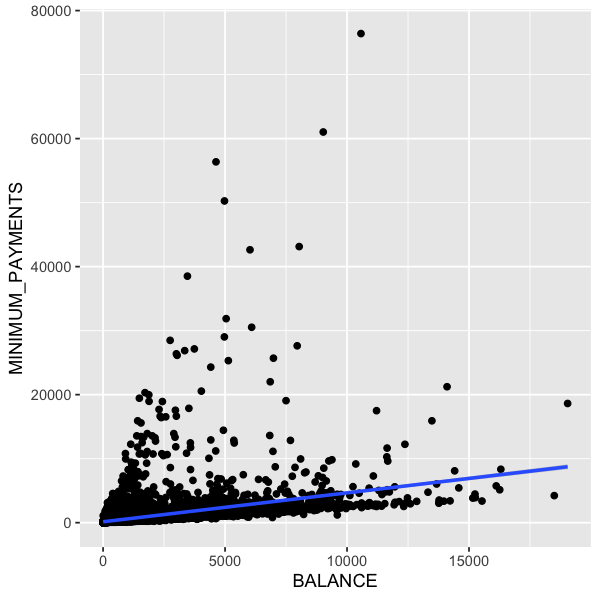

In [14]:
options(repr.plot.width=5, repr.plot.height=5)
qplot(BALANCE, MINIMUM_PAYMENTS, data=na.omit(df)) + geom_smooth(method="lm")

### Compute predictions for missing values

First, we obtain, a linear model for MINIMU_PAYMRNTS depending linearly on the BALANCE values:

In [15]:
lm_missing <- lm(MINIMUM_PAYMENTS~BALANCE, data=df)

Now, we compute the required predictions for missing values in the MINIMUM_PAYMENTS column:

In [16]:
df_missing <- subset(df, subset=is.na(df$MINIMUM_PAYMENTS), select=BALANCE)

In [17]:
missing_predictions <- predict(lm_missing, df_missing)

Now, we replace the missing values with the obtained predictions:

In [18]:
df$MINIMUM_PAYMENTS[is.na(df$MINIMUM_PAYMENTS)] <- missing_predictions

Let's omit the only observation that has missing value in CREDIT_LIMIT. Omitting one observation will not affect our dataset:

In [19]:
df_withoutMissingValues <- na.omit(df)

In [20]:
dim(df_withoutMissingValues)

[1] 8949   17

# Box-Cox Transformation

Now, it is time to take care of skewness in our dataset. First, let's have a look at the summary of our data:

In [21]:
summary(df_withoutMissingValues)

    BALANCE        BALANCE_FREQUENCY   PURCHASES       ONEOFF_PURCHASES 
 Min.   :    0.0   Min.   :0.0000    Min.   :    0.0   Min.   :    0.0  
 1st Qu.:  128.4   1st Qu.:0.8889    1st Qu.:   39.8   1st Qu.:    0.0  
 Median :  873.7   Median :1.0000    Median :  361.5   Median :   38.0  
 Mean   : 1564.6   Mean   :0.8774    Mean   : 1003.3   Mean   :  592.5  
 3rd Qu.: 2054.4   3rd Qu.:1.0000    3rd Qu.: 1110.2   3rd Qu.:  577.8  
 Max.   :19043.1   Max.   :1.0000    Max.   :49039.6   Max.   :40761.2  
 INSTALLMENTS_PURCHASES  CASH_ADVANCE   PURCHASES_FREQUENCY
 Min.   :    0.0        Min.   :    0   Min.   :0.00000    
 1st Qu.:    0.0        1st Qu.:    0   1st Qu.:0.08333    
 Median :   89.0        Median :    0   Median :0.50000    
 Mean   :  411.1        Mean   :  979   Mean   :0.49041    
 3rd Qu.:  468.6        3rd Qu.: 1114   3rd Qu.:0.91667    
 Max.   :22500.0        Max.   :47137   Max.   :1.00000    
 ONEOFF_PURCHASES_FREQUENCY PURCHASES_INSTALLMENTS_FREQUENCY
 Min.   

 we want to apply Box-Cox transformation to take care of the skewness of the data. However, the minimum values for some of the features equal zero. Therefore, we add a constant term to those features in order to avoid having $log(0)$. In what follows, we have defined the appropriate constant values considering the range of the features:

In [22]:
CON <- data.frame("BALANCE"=1, "BALANCE_FREQUENCY"=1, "PURCHASES"=1, "ONEOFF_PURCHASES"=1,
           "INSTALLMENTS_PURCHASES"=1, "CASH_ADVANCE"=1, "PURCHASES_FREQUENCY"=0.1,
           "ONEOFF_PURCHASES_FREQUENCY"=0.001, "PURCHASES_INSTALLMENTS_FREQUENCY"=0.001,
           "CASH_ADVANCE_FREQUENCY"=0.001, "CASH_ADVANCE_TRX"=0.001, "PURCHASES_TRX"=0.01, 
           "CREDIT_LIMIT"=0, "PAYMENTS"=1, "MINIMUM_PAYMENTS"=0, "PRC_FULL_PAYMENT"=0.001,
           "TENURE"=0
           )

Following, you can see a summary of the constant values:

In [23]:
str(CON)

'data.frame':	1 obs. of  17 variables:
 $ BALANCE                         : num 1
 $ BALANCE_FREQUENCY               : num 1
 $ PURCHASES                       : num 1
 $ ONEOFF_PURCHASES                : num 1
 $ INSTALLMENTS_PURCHASES          : num 1
 $ CASH_ADVANCE                    : num 1
 $ PURCHASES_FREQUENCY             : num 0.1
 $ ONEOFF_PURCHASES_FREQUENCY      : num 0.001
 $ PURCHASES_INSTALLMENTS_FREQUENCY: num 0.001
 $ CASH_ADVANCE_FREQUENCY          : num 0.001
 $ CASH_ADVANCE_TRX                : num 0.001
 $ PURCHASES_TRX                   : num 0.01
 $ CREDIT_LIMIT                    : num 0
 $ PAYMENTS                        : num 1
 $ MINIMUM_PAYMENTS                : num 0
 $ PRC_FULL_PAYMENT                : num 0.001
 $ TENURE                          : num 0


Now, in what follows, we compute the optimal values of lambda for applying Box-Cox transformation:

In [24]:
lambdas = c()
for(name in names(df_withoutMissingValues)){
    b <- boxcox(lm(df_withoutMissingValues[[name]]+ CON[[name]] ~ 1), plotit = FALSE)
    lambda <- b$x[which.max(b$y)]
    lambdas[[name]] = lambda  
}

In the following, you can see the summary of the obtained optimal values for lambda we will use in Box-Cox transformation:

In [25]:
str(lambdas)

List of 17
 $ BALANCE                         : num 0.2
 $ BALANCE_FREQUENCY               : num 2
 $ PURCHASES                       : num 0.2
 $ ONEOFF_PURCHASES                : num -0.1
 $ INSTALLMENTS_PURCHASES          : num 0
 $ CASH_ADVANCE                    : num -0.1
 $ PURCHASES_FREQUENCY             : num 0.4
 $ ONEOFF_PURCHASES_FREQUENCY      : num 0
 $ PURCHASES_INSTALLMENTS_FREQUENCY: num 0.1
 $ CASH_ADVANCE_FREQUENCY          : num -0.1
 $ CASH_ADVANCE_TRX                : num 0
 $ PURCHASES_TRX                   : num 0.2
 $ CREDIT_LIMIT                    : num 0.1
 $ PAYMENTS                        : num 0.2
 $ MINIMUM_PAYMENTS                : num 0
 $ PRC_FULL_PAYMENT                : num -0.4
 $ TENURE                          : num 2


Now, we apply the Box-Cox transformation on all the columns of our data frame leveraging the previousely obtaind optimal values for lambda:

In [26]:
bc <- function(obs, con, lambda) { 
    if(lambda != 0) ((obs+con)^lambda-1)/lambda 
    else log(obs + con)
    }
df_boxcox <- mapply(bc, df_withoutMissingValues, CON, lambdas)

In [27]:
df_boxcox=data.frame(df_boxcox)

Now, let's have a look at our transformed dataset:

In [28]:
head(df_boxcox, 3)

BALANCE   BALANCE_FREQUENCY PURCHASES ONEOFF_PURCHASES INSTALLMENTS_PURCHASES
1  5.553934 1.152893           7.467673 0.000000         4.568506              
2 20.124306 1.322314           0.000000 0.000000         0.000000              
3 18.901442 1.500000          13.911992 4.858186         0.000000              
  CASH_ADVANCE PURCHASES_FREQUENCY ONEOFF_PURCHASES_FREQUENCY
1 0.000000     -1.0265761          -6.9077552790             
2 5.840082     -1.5047321          -6.9077552790             
3 0.000000      0.0971503           0.0009995003             
  PURCHASES_INSTALLMENTS_FREQUENCY CASH_ADVANCE_FREQUENCY CASH_ADVANCE_TRX
1 -2.190922                        -9.952623              -6.907755       
2 -4.988128                        -1.482399               1.386544       
3 -4.988128                        -9.952623              -6.907755       
  PURCHASES_TRX CREDIT_LIMIT PAYMENTS MINIMUM_PAYMENTS PRC_FULL_PAYMENT TENURE
1  0.7492238     9.952623     9.46720 4.938135         -37.122330       71.5  
2 -3.0094641    14.238727    21.40050 6.977599          -2.054547       71.5  
3  3.2201285    14.406535    13.10827 6.441401         -37.122330       71.5

Now, as the last step, we compare the skewness of the dataset before and after applying the Box-Cox transformation:

In [29]:
data.frame(skewness_after_BoxCox_Transformation=skewness(df_boxcox),
           skewness_of_Original_Data=skewness(df, na.rm=TRUE))

skewness_after_BoxCox_Transformation
BALANCE                          -0.11093079                         
BALANCE_FREQUENCY                -1.82142864                         
PURCHASES                        -0.03589246                         
ONEOFF_PURCHASES                  0.07730727                         
INSTALLMENTS_PURCHASES           -0.02520163                         
CASH_ADVANCE                      0.17814571                         
PURCHASES_FREQUENCY              -0.23198604                         
ONEOFF_PURCHASES_FREQUENCY        0.06718335                         
PURCHASES_INSTALLMENTS_FREQUENCY -0.13255344                         
CASH_ADVANCE_FREQUENCY            0.12598931                         
CASH_ADVANCE_TRX                  0.15114637                         
PURCHASES_TRX                    -0.25956059                         
CREDIT_LIMIT                      0.06406478                         
PAYMENTS                          0.12302350                         
MINIMUM_PAYMENTS                  0.04631547                         
PRC_FULL_PAYMENT                  0.68235580                         
TENURE                           -2.74002926                         
                                 skewness_of_Original_Data
BALANCE                           2.39298490              
BALANCE_FREQUENCY                -2.02292641              
PURCHASES                         8.14290404              
ONEOFF_PURCHASES                 10.04339927              
INSTALLMENTS_PURCHASES            7.29789654              
CASH_ADVANCE                      5.16574312              
PURCHASES_FREQUENCY               0.06015415              
ONEOFF_PURCHASES_FREQUENCY        1.53535541              
PURCHASES_INSTALLMENTS_FREQUENCY  0.50911582              
CASH_ADVANCE_FREQUENCY            1.82837977              
CASH_ADVANCE_TRX                  5.72033928              
PURCHASES_TRX                     4.62987914              
CREDIT_LIMIT                      1.52220880              
PAYMENTS                          5.90662964              
MINIMUM_PAYMENTS                 13.81252425              
PRC_FULL_PAYMENT                  1.94249431              
TENURE                           -2.94252402

One can see, that we managed to significantly reduce the skewness of our data.

To evaluate it further, let's have a look at the histograms related to the columns of our dataset:

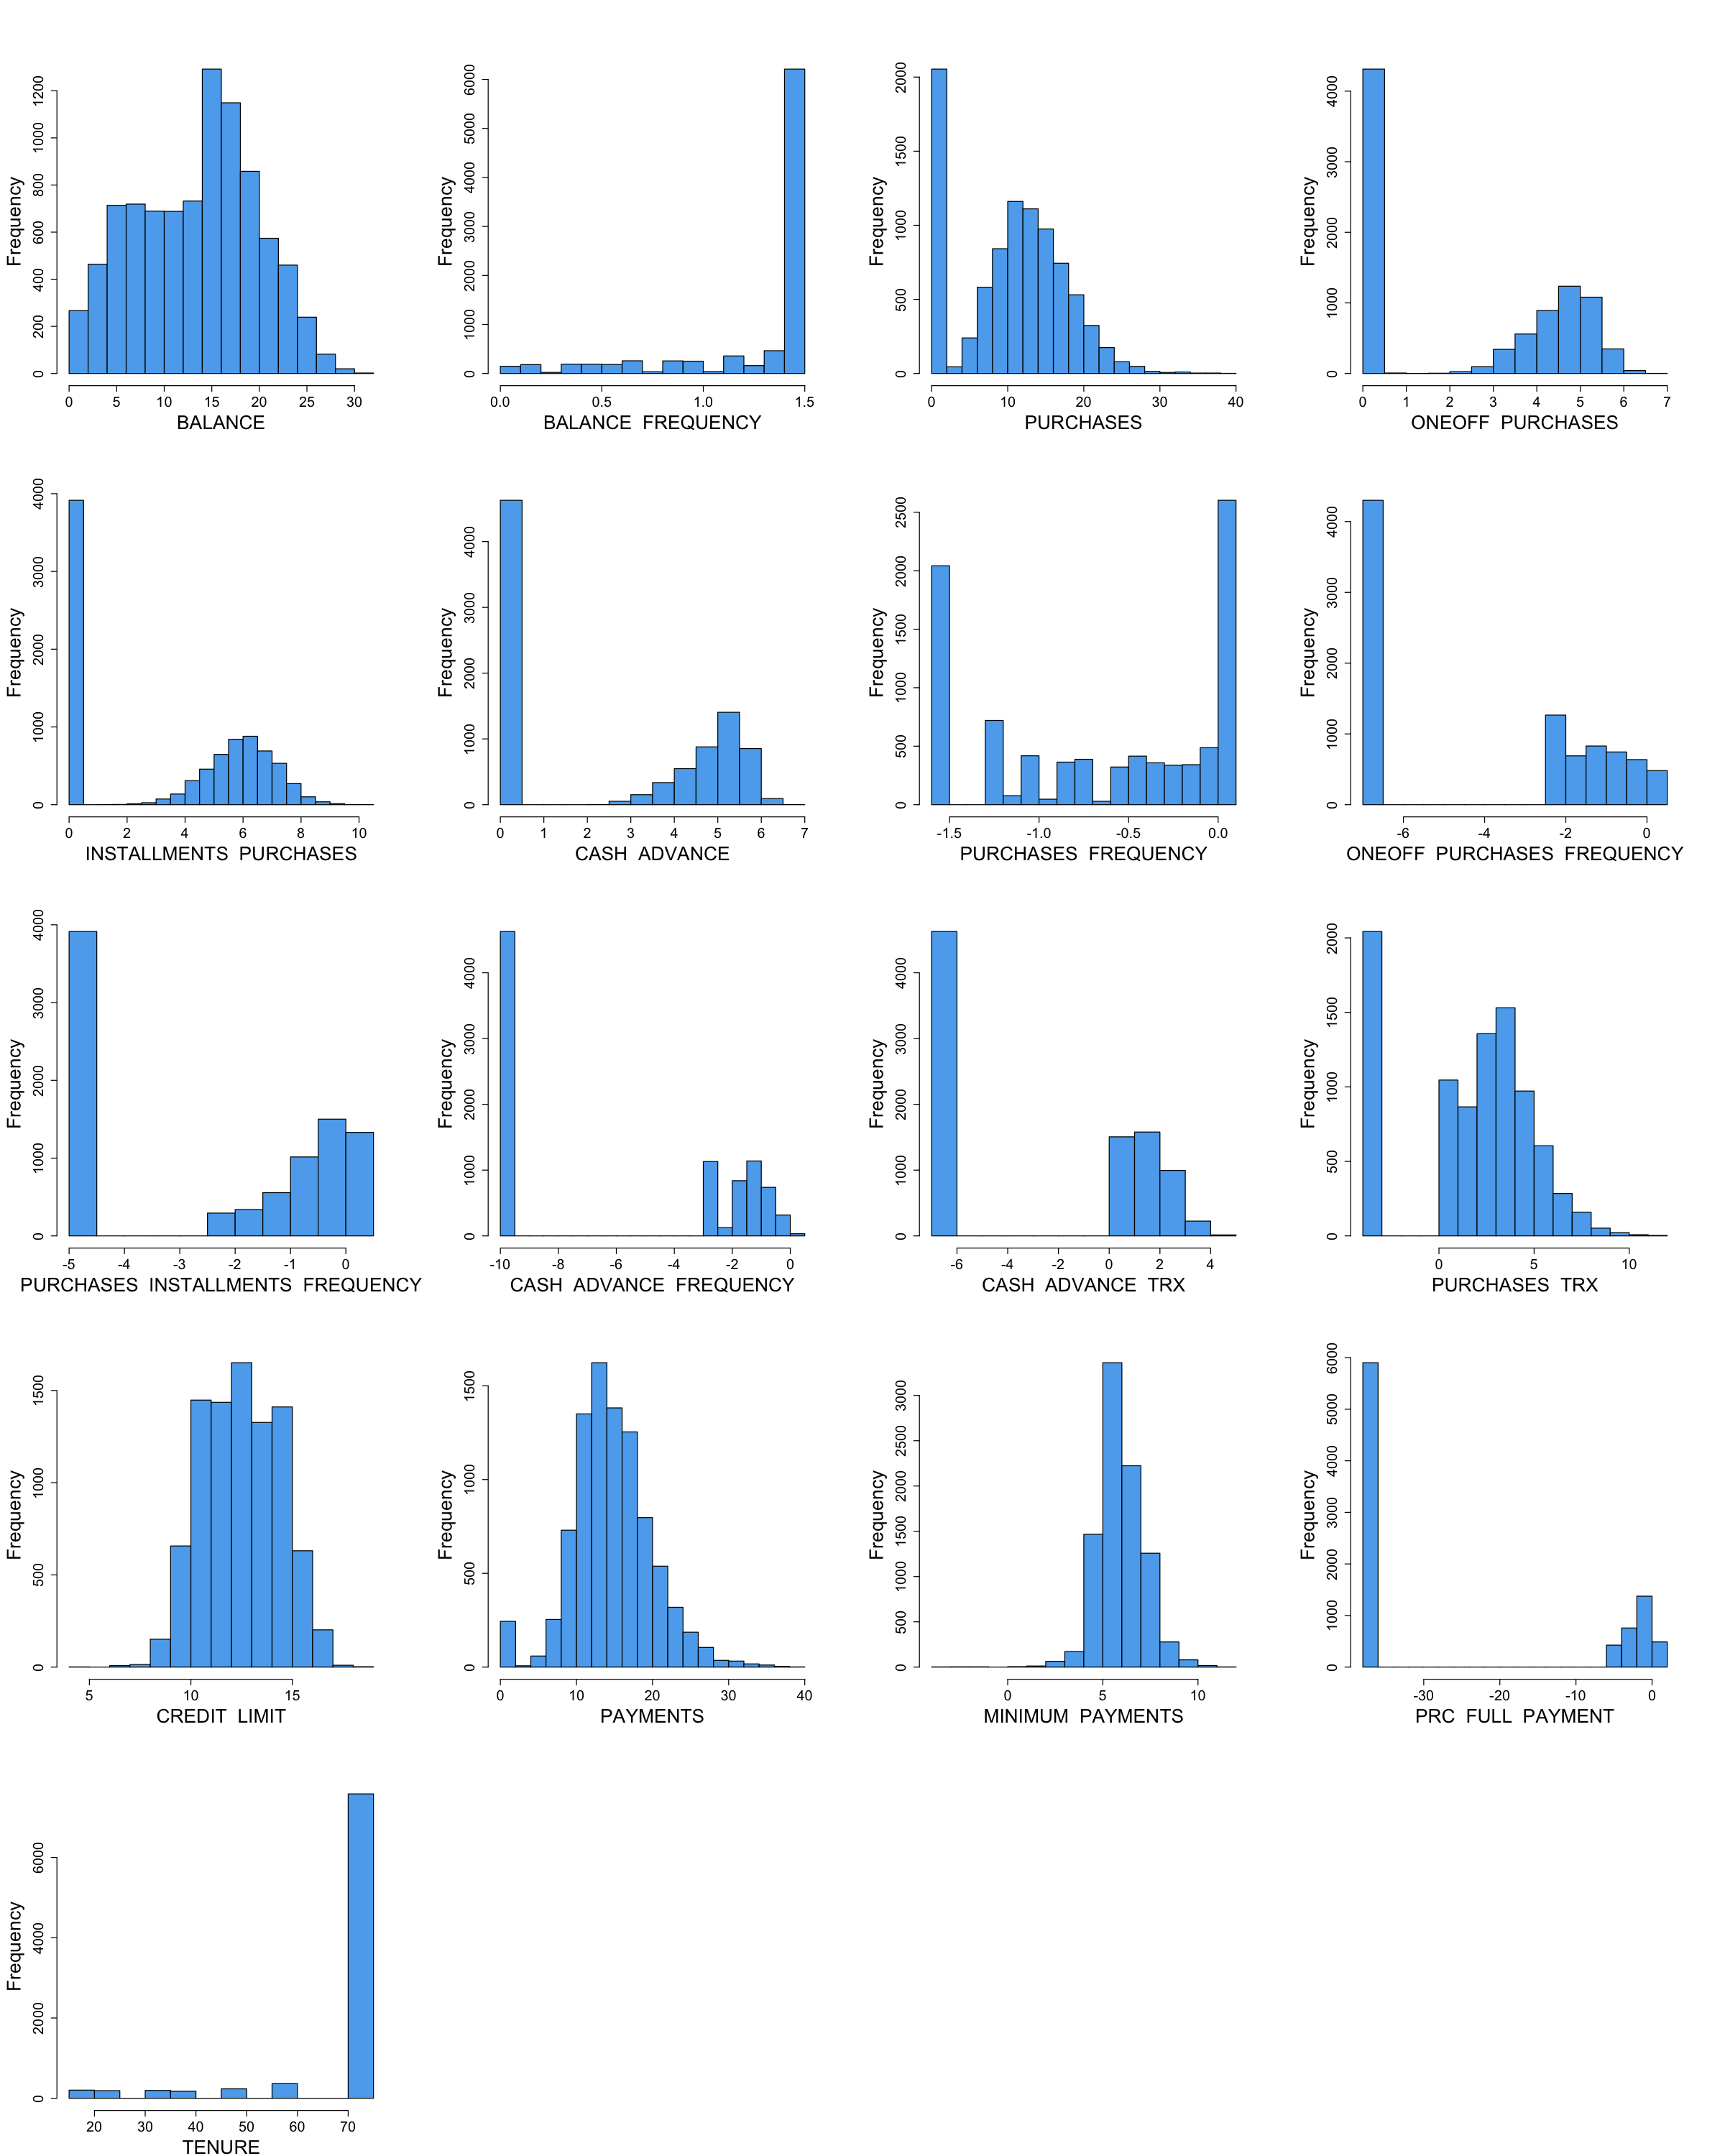

In [30]:
options(repr.plot.width=20, repr.plot.height=25)

par(mfrow=c(5,4), mar=c(4,5,5,4), cex.lab=2, cex.axis=1.5)
for(name in names(df_boxcox)) {
   hist(df_boxcox[[name]], xlab=name, main="", col="Steelblue2")
}

Again, one can see that the skewness has reduced significantly.

# Outliers

Leveraging boxplot with whiskers, let's have a look at the distributions of the features to investigate the presence of outliers:

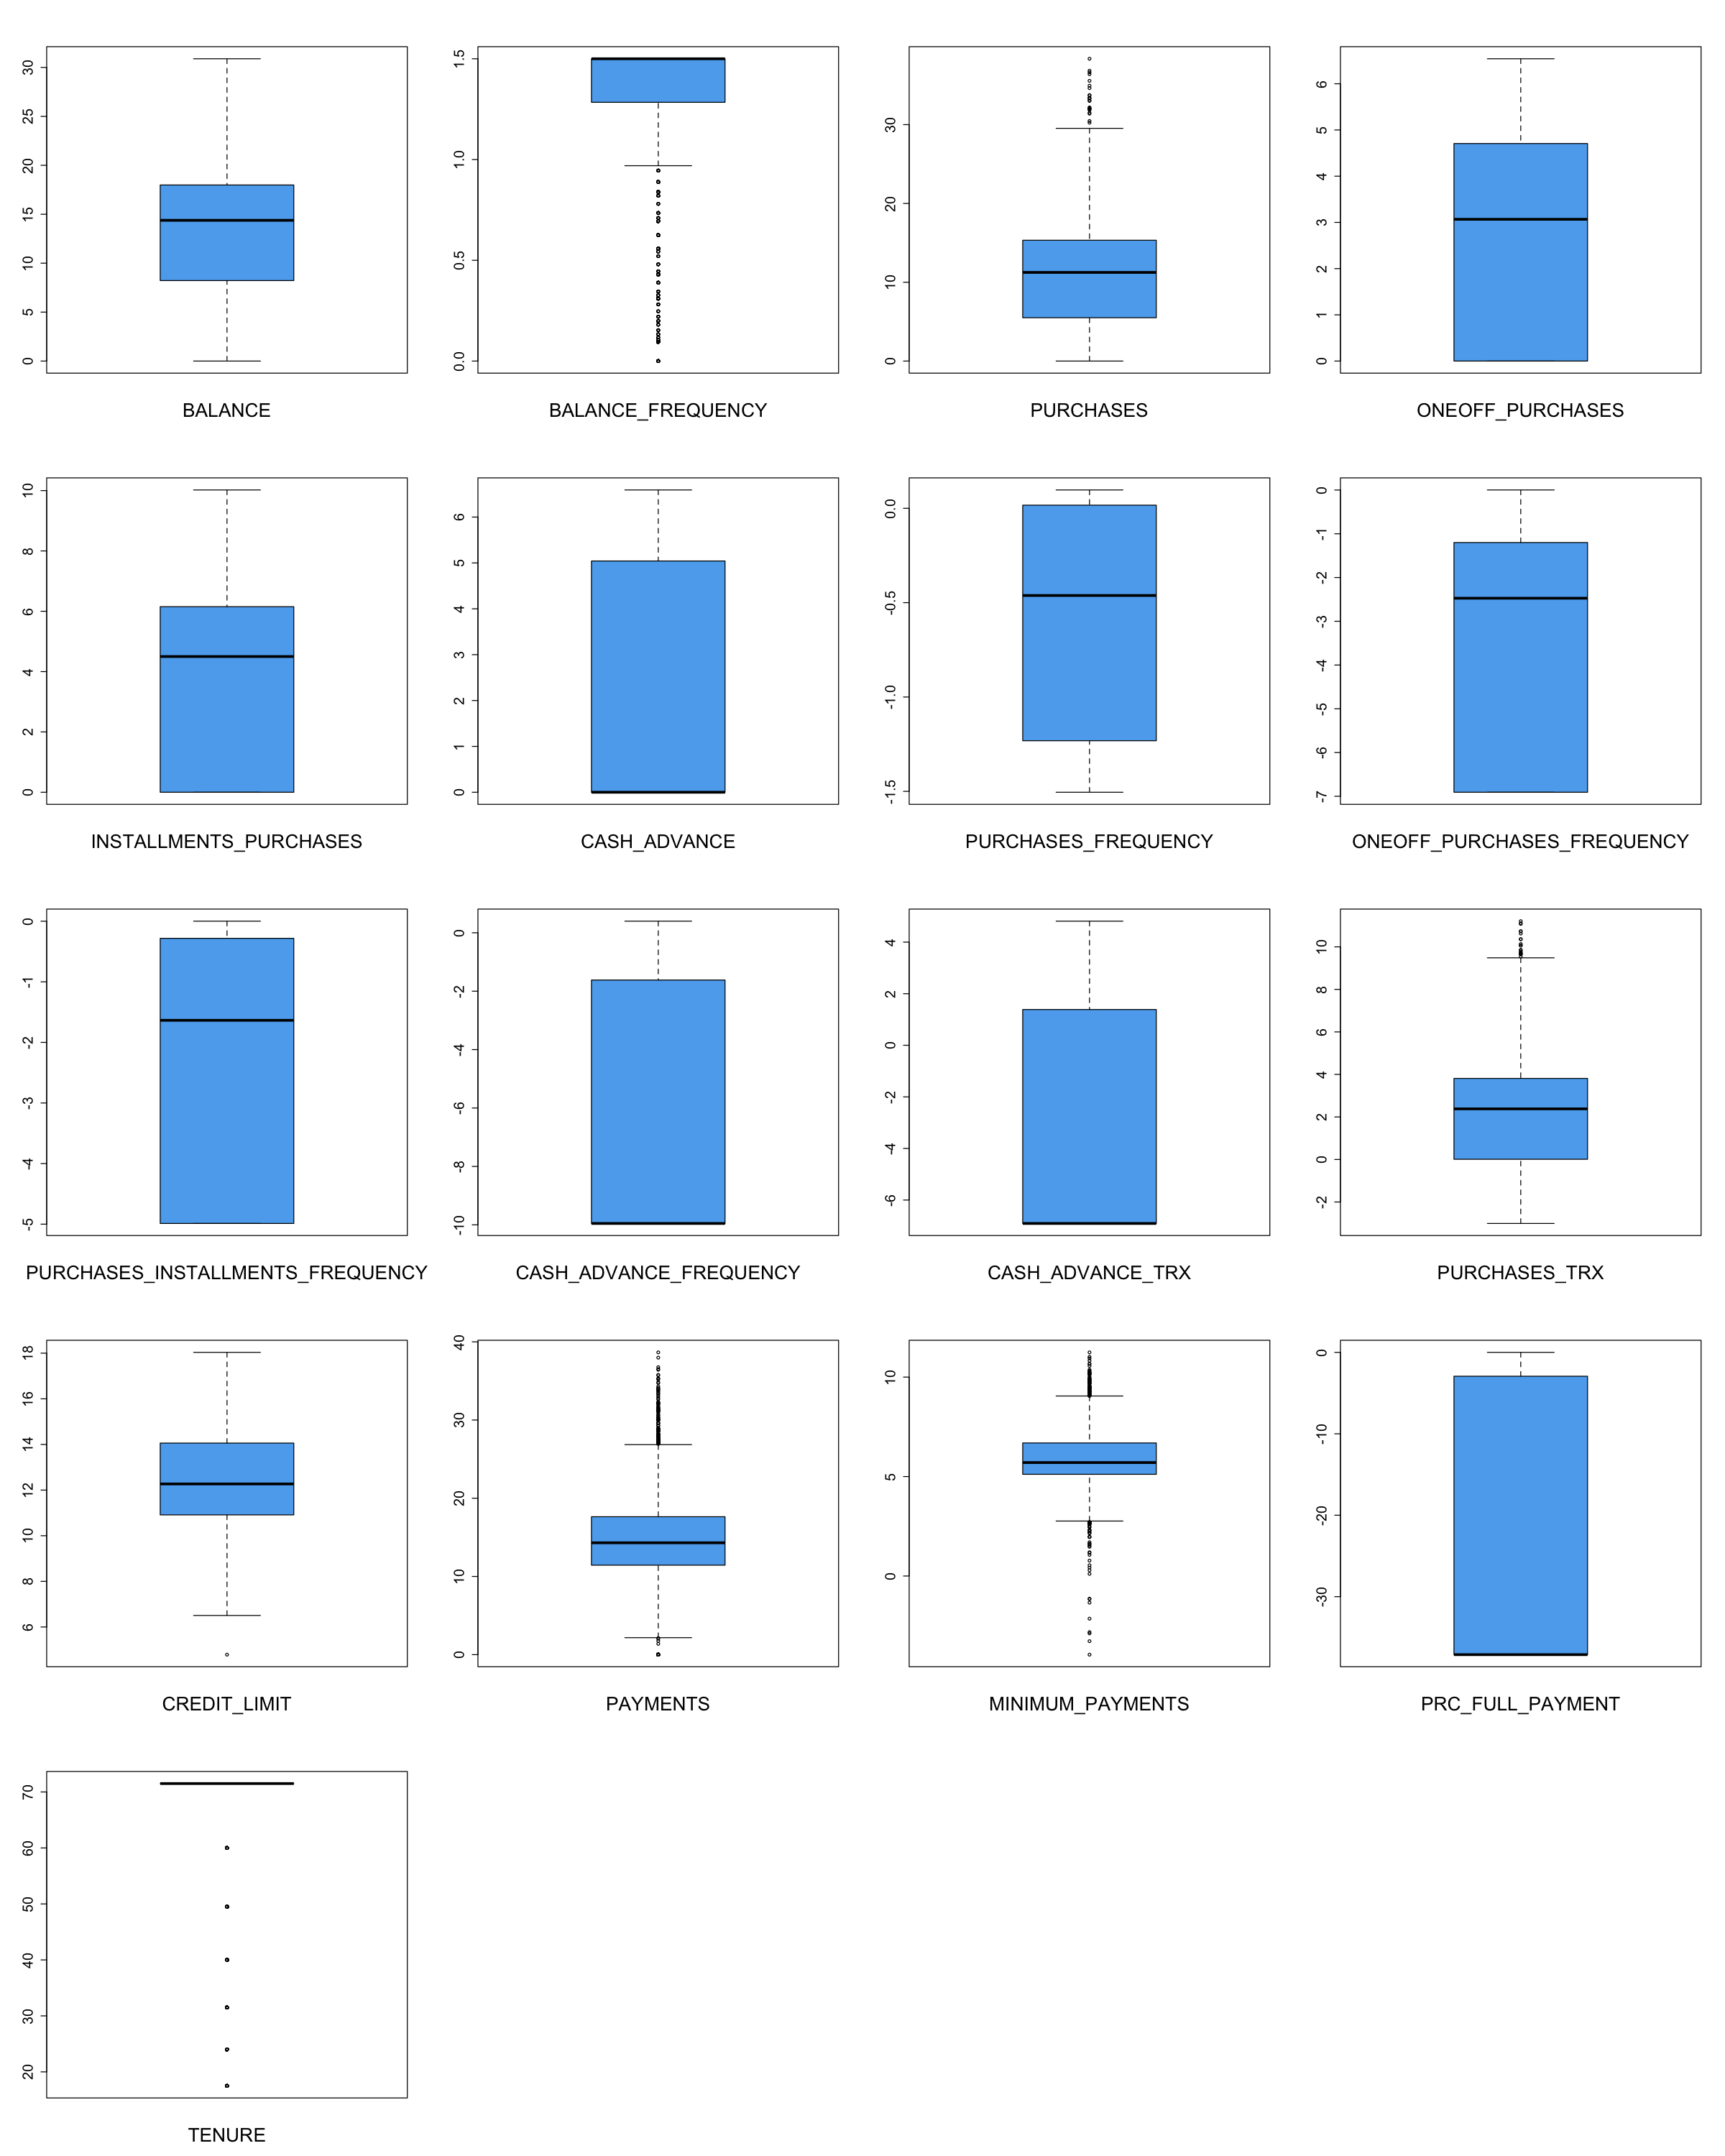

In [31]:
options(repr.plot.width=20, repr.plot.height=25)
par(mfrow=c(5,4), cex.lab=2, cex.axis=1.5)

for(name in names(df_boxcox)) {
   boxplot(x=df_boxcox[[name]], xlab=name, col="steelblue2")
}

As one can see, there exist some outliers in our dataset.

Now, we consider  z_score =3 as a cut-off value to eliminate the outliers:

In [32]:
df_scaled <- scale(df_boxcox, center = TRUE, scale = TRUE)
mask <- apply(abs(df_scaled) < 3, 1, all)
df_tidy <- df_boxcox[mask,]
dim(df_tidy)

[1] 8266   17

After omitting the related outliers, we finally obtain our tidy dataset.

# PCA

Now, we use PCA  to reduce dimensionality of data by replacing several correlated features with a new set of features that are linear combinations of the original ones.

In [33]:
pc <- prcomp(df_tidy, retx = TRUE, center = TRUE, scale = TRUE)

In [34]:
summary(pc)

Importance of components:
                          PC1    PC2    PC3     PC4     PC5     PC6     PC7
Standard deviation     2.5002 1.9129 1.3211 1.15176 1.06090 0.92413 0.85928
Proportion of Variance 0.3677 0.2152 0.1027 0.07803 0.06621 0.05024 0.04343
Cumulative Proportion  0.3677 0.5830 0.6856 0.76366 0.82986 0.88010 0.92353
                           PC8    PC9    PC10    PC11    PC12    PC13    PC14
Standard deviation     0.72500 0.5698 0.42748 0.32568 0.27933 0.20130 0.13474
Proportion of Variance 0.03092 0.0191 0.01075 0.00624 0.00459 0.00238 0.00107
Cumulative Proportion  0.95445 0.9736 0.98430 0.99054 0.99513 0.99752 0.99858
                          PC15    PC16    PC17
Standard deviation     0.12455 0.07504 0.05417
Proportion of Variance 0.00091 0.00033 0.00017
Cumulative Proportion  0.99950 0.99983 1.00000

In [35]:
str(pc)

List of 5
 $ sdev    : num [1:17] 2.5 1.91 1.32 1.15 1.06 ...
 $ rotation: num [1:17, 1:17] 0.1583 0.0101 -0.3442 -0.205 -0.3071 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:17] "BALANCE" "BALANCE_FREQUENCY" "PURCHASES" "ONEOFF_PURCHASES" ...
  .. ..$ : chr [1:17] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : Named num [1:17] 13.69 1.32 10.51 2.43 3.39 ...
  ..- attr(*, "names")= chr [1:17] "BALANCE" "BALANCE_FREQUENCY" "PURCHASES" "ONEOFF_PURCHASES" ...
 $ scale   : Named num [1:17] 6.128 0.348 7.016 2.343 3.087 ...
  ..- attr(*, "names")= chr [1:17] "BALANCE" "BALANCE_FREQUENCY" "PURCHASES" "ONEOFF_PURCHASES" ...
 $ x       : num [1:8266, 1:17] -0.242 3.724 -1.155 1.61 0.694 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:8266] "1" "2" "3" "4" ...
  .. ..$ : chr [1:17] "PC1" "PC2" "PC3" "PC4" ...
 - attr(*, "class")= chr "prcomp"


In [36]:
head(pc$x, 3)

PC1        PC2       PC3        PC4       PC5        PC6        PC7       
1 -0.2423327  3.046558  0.7016240  1.233236 -0.1279754  0.3711201  0.4133872
2  3.7236906 -0.684012  0.3624691 -1.776399 -1.6566571 -0.4837447 -0.9161392
3 -1.1549801 -1.072705 -2.0996623  1.685439 -0.7184714 -0.4652299 -0.3470425
  PC8        PC9        PC10       PC11       PC12       PC13       
1 -0.4736862 -0.5403783  0.2073384 -0.3050901 -0.4035338  0.20815403
2 -0.1775501  0.5784596  0.2317417  0.1540785  0.2801704 -0.02635198
3  0.5892211  0.3159502 -1.0298323  0.4393753  0.5516528 -0.36105684
  PC14        PC15        PC16       PC17        
1 -0.12623197 -0.11052117 0.03084779  0.012157210
2  0.05708539 -0.18386879 0.01041461 -0.064811874
3 -0.23046716  0.01450839 0.06397100  0.007520441

Now to choose the appropriate number of principal components, we compute and illustrate the cumulative proportion of variance explained by PCA as follows:

In [37]:
pc_sdv <- pc$sdev
pc_var <- pc_sdv^2

# proportion of variance
prop_var <- pc_var/sum(pc_var)

# cumulative proportion of variance
com_prop <- cumsum(prop_var)

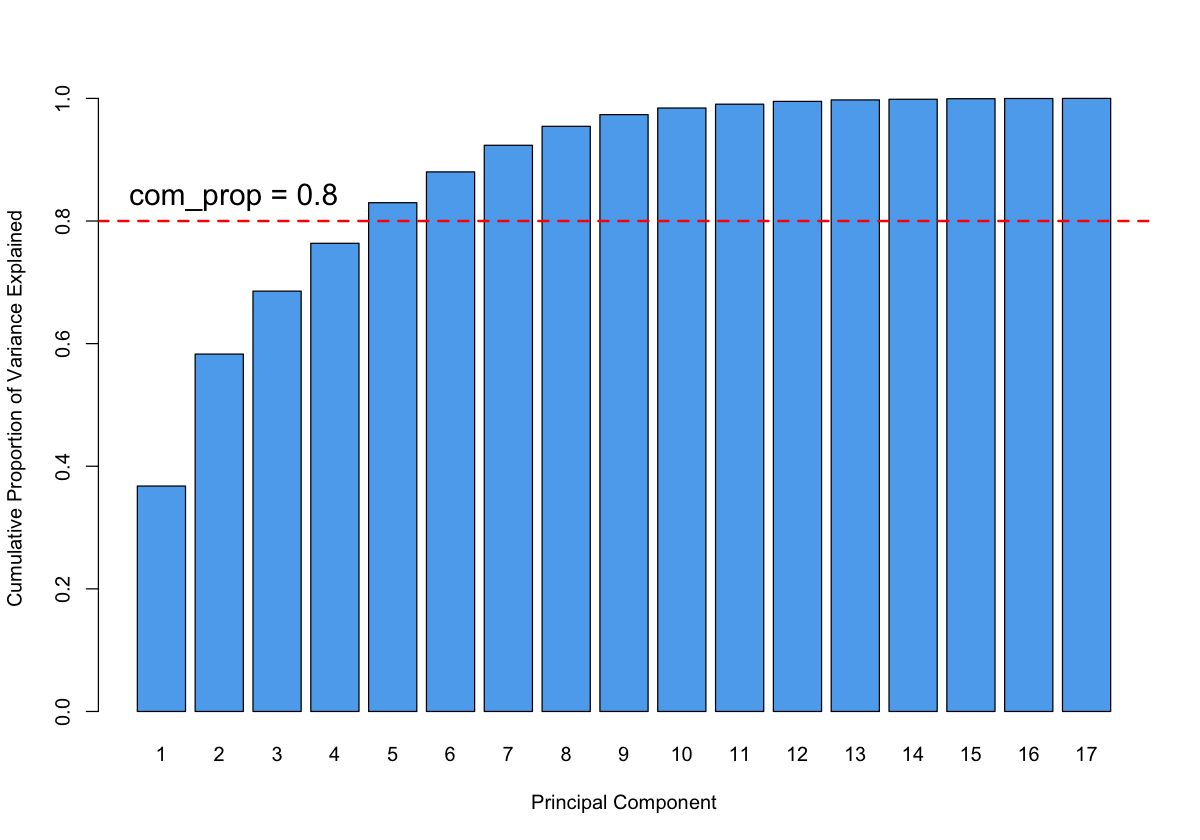

In [38]:
options(repr.plot.width=10, repr.plot.height=7)
barplot(com_prop, col="steelblue2", xlab="Principal Component", 
        ylab="Cumulative Proportion of Variance Explained",
       names.arg=1:length(prop_var))
abline(h=0.8, col="red", lwd=2, lty=2)
text(2.2,0.84, labels="com_prop = 0.8", cex=1.5)

From the above figure, using just 5 principal components, one can keep over 80% of the variance in the original data.

In [39]:
pc <- prcomp(df_tidy, retx = TRUE, center = TRUE, scale = TRUE, rank=5)
dat <- pc$x
head(dat, 3)

PC1        PC2       PC3        PC4       PC5       
1 -0.2423327  3.046558  0.7016240  1.233236 -0.1279754
2  3.7236906 -0.684012  0.3624691 -1.776399 -1.6566571
3 -1.1549801 -1.072705 -2.0996623  1.685439 -0.7184714

The obtained data frame is used for the clustering purposes in the sequel. 

# Clustering

## Hierarchical Clustering

Now, we consider hierarchical clustering to cluster our data: 

In [40]:
hcluster <- dat %>% dist %>% hclust
hcluster


Call:
hclust(d = .)

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 8266 


Now, let us cut the obtained tree into 3, 4, and 5 clusters, respectively:

In [41]:
cl3 <- cutree(hcluster, k=3)
cl4 <- cutree(hcluster, k=4)
cl5 <- cutree(hcluster, k=5)

Now, let's have a visualization of obtained clusters as follows:

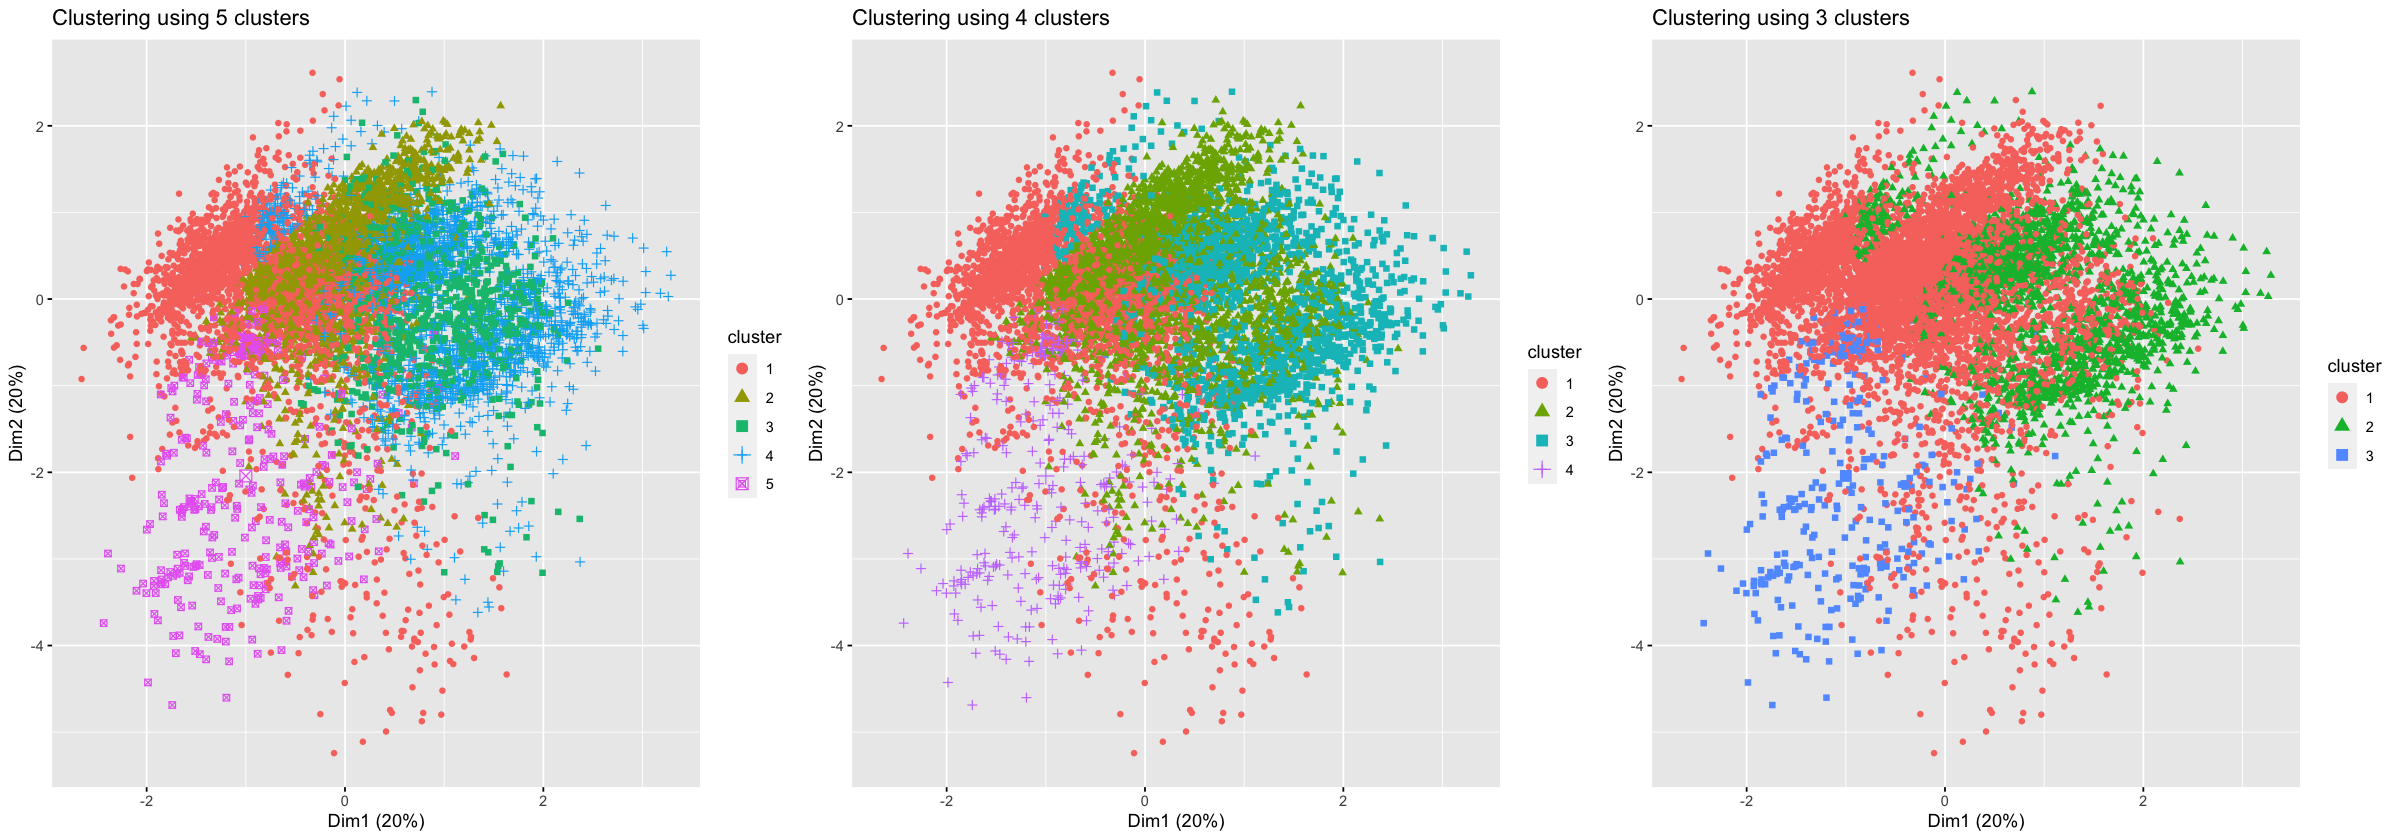

In [42]:
p5 <- fviz_cluster(list(data = dat, cluster = cl5), data= dat, geom="point", ellipse.type="stat_ellipse",
                    main="Clustering using 5 clusters")
p4 <- fviz_cluster(list(data = dat, cluster = cl4), data= dat, geom="point", ellipse.type="stat_ellipse",
                    main="Clustering using 4 clusters")
p3 <- fviz_cluster(list(data = dat, cluster = cl3), data= dat, geom="point", ellipse.type="stat_ellipse",
                    main="Clustering using 3 clusters")

options(repr.plot.width=20, repr.plot.height=7)
grid.arrange(p5, p4, p3, ncol=3)

## Kmeans Clustering

Now, we use K means clustering to obtain the cluters:

We apply Kmeans considering 2 to 15 clusters:

In [43]:
centers = 2:15
myFun <- function(centers, ...){ 
    res <- kmeans(centers = centers, ...)
    res$tot.withinss
}
ss <- mapply(myFun, centers=centers, MoreArgs = list(x = dat, iter.max = 500, nstart = 50))

Now, let's have a look at the sum of squares for the obtained clusters considering 2 to 15 clusters:

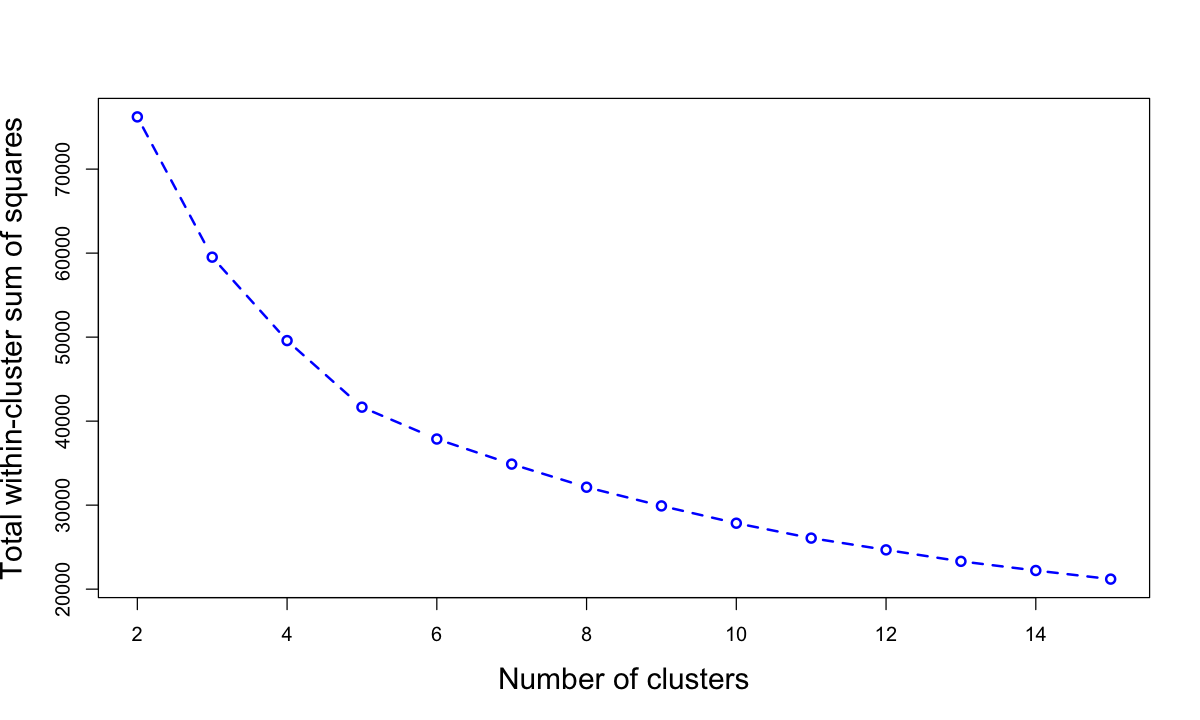

In [44]:
options(repr.plot.width=10, repr.plot.height=6)
plot(centers, ss, type="b", col="blue", lwd=2, lty=2, cex.lab=1.5, 
     xlab="Number of clusters", ylab="Total within-cluster sum of squares")

Based on elbow method, it seems that either 4 or 5 clusters are the optimal number of clusters for the problem at hand.

Now, let's visualize the obtained clusters considering the clustering problem with 3, 4, or 5 clusters as follows:

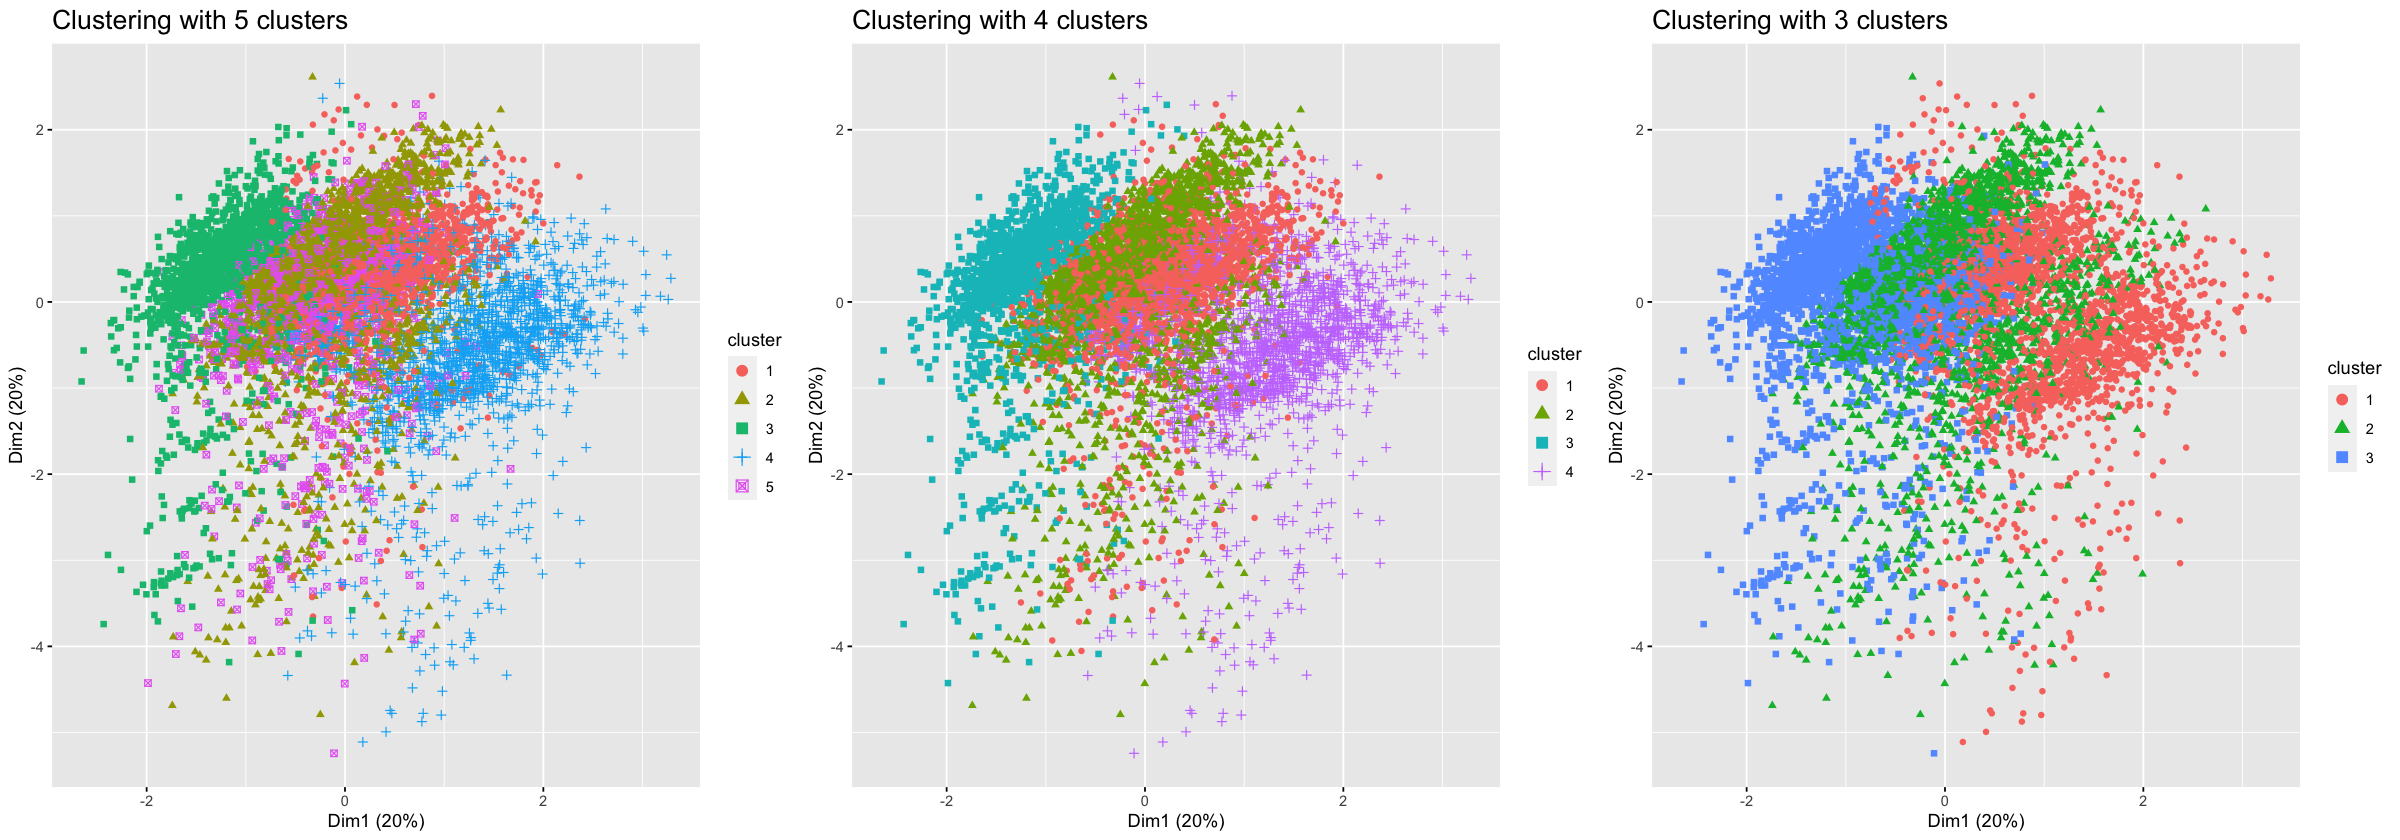

In [45]:
cl3 <- kmeans(x = dat, centers=3, iter.max = 100, nstart = 10)
cl4 <- kmeans(x = dat, centers=4, iter.max = 100, nstart = 10)
cl5 <- kmeans(x = dat, centers=5, iter.max = 100, nstart = 10)

p3 <- fviz_cluster(cl3, data= dat, geom="point", ellipse.type="stat_ellipse", main="Clustering with 3 clusters", font.main=16)
p4 <- fviz_cluster(cl4, data= dat, geom="point", ellipse.type="stat_ellipse", main="Clustering with 4 clusters", font.main=16)
p5 <- fviz_cluster(cl5, data= dat, geom="point", ellipse.type="stat_ellipse", main="Clustering with 5 clusters", font.main=16)

options(repr.plot.width=20, repr.plot.height=7)
grid.arrange(p5, p4, p3, ncol=3)

It seems that considering the clustering problem with 4 clusters results in good performance.

Let's also have a look at the silhouette score:

  cluster size ave.sil.width
1       1 2664          0.21
2       2 2511          0.45
3       3 3091          0.26
  cluster size ave.sil.width
1       1 2562          0.22
2       2 2210          0.46
3       3 1781          0.36
4       4 1713          0.25
  cluster size ave.sil.width
1       1 1577          0.35
2       2 2142          0.46
3       3 1716          0.34
4       4 1689          0.22
5       5 1142          0.27


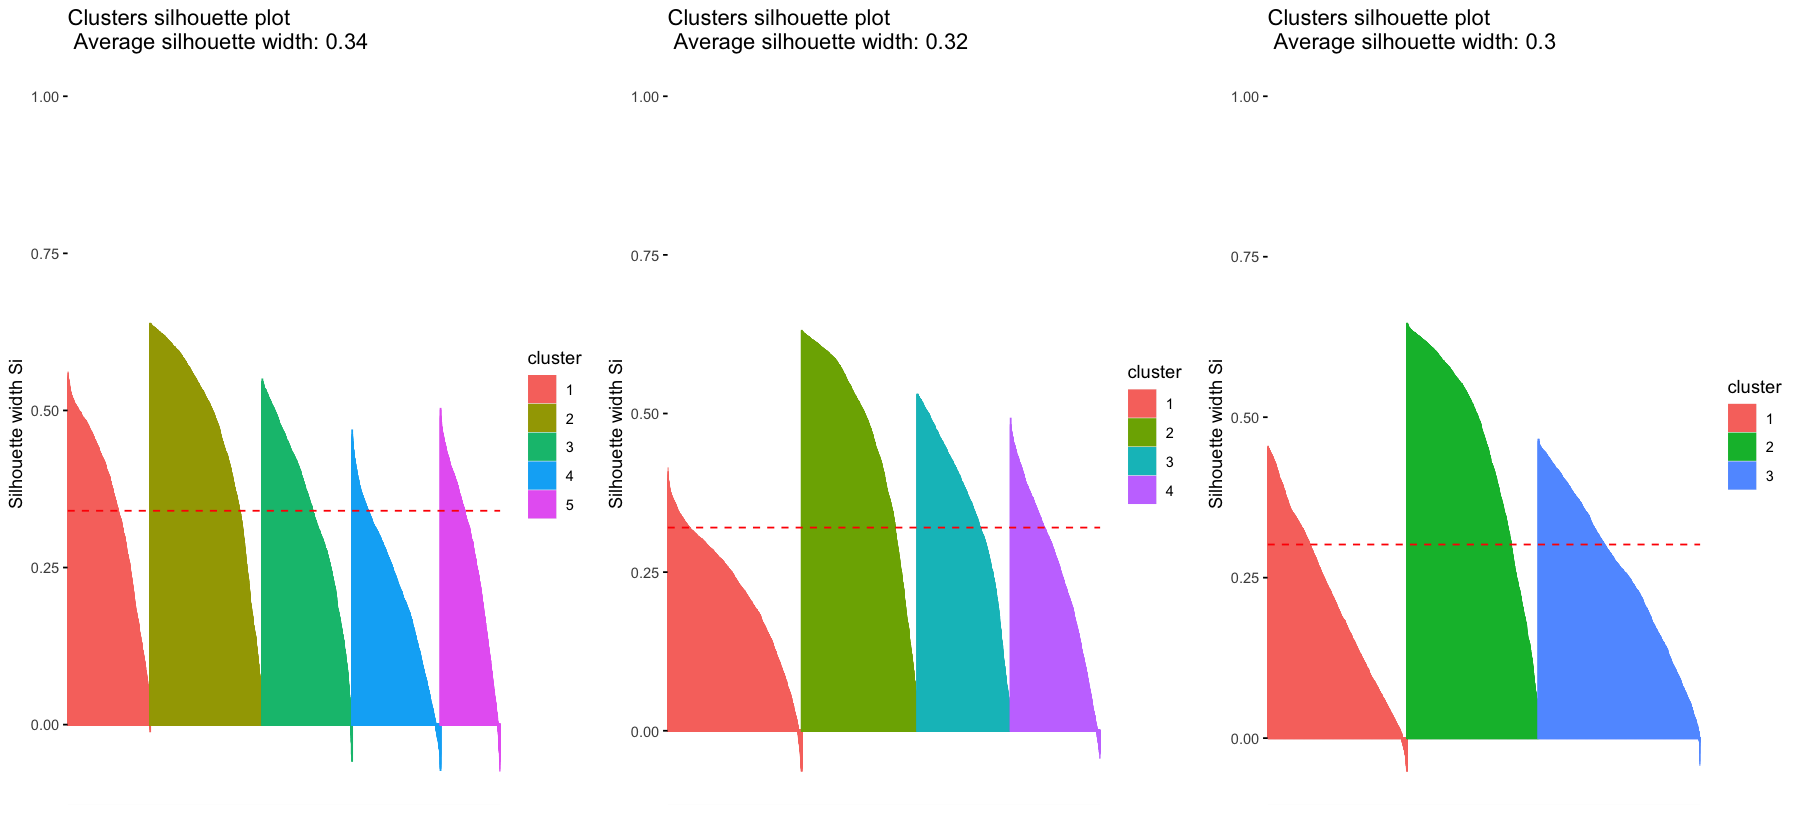

In [46]:
sil3 <- silhouette(cl3$cluster, dist(dat))
sil4 <- silhouette(cl4$cluster, dist(dat))
sil5 <- silhouette(cl5$cluster, dist(dat))

s3 <- fviz_silhouette(sil3)
s4 <- fviz_silhouette(sil4)
s5 <- fviz_silhouette(sil5)

options(repr.plot.width=15, repr.plot.height=7)
grid.arrange(s5, s4, s3, ncol=3)

# Cluster Analysis

Now, we can compare the features of different clusters as follows:

In [47]:
cl <- kmeans(x = dat, centers=4, iter.max = 100, nstart = 10)

In [48]:
df_tidy <- df_tidy %>% mutate(cluster=factor(cl$cluster))
head(df_tidy)

BALANCE   BALANCE_FREQUENCY PURCHASES ONEOFF_PURCHASES INSTALLMENTS_PURCHASES
1  5.553934 1.1528929          7.467673 0.000000         4.568506              
2 20.124306 1.3223142          0.000000 0.000000         0.000000              
3 18.901442 1.5000000         13.911992 4.858186         0.000000              
4 17.049160 0.8388436         16.586799 5.187277         0.000000              
5 14.124782 1.5000000          3.811702 2.467223         0.000000              
6 17.415348 1.5000000         16.087223 0.000000         7.196147              
  CASH_ADVANCE PURCHASES_FREQUENCY ONEOFF_PURCHASES_FREQUENCY
1 0.000000     -1.0265761          -6.9077552790             
2 5.840082     -1.5047321          -6.9077552790             
3 0.000000      0.0971503           0.0009995003             
4 4.132576     -1.2316583          -2.4729820315             
5 0.000000     -1.2316583          -2.4729820315             
6 0.000000     -0.2520703          -6.9077552790             
  PURCHASES_INSTALLMENTS_FREQUENCY CASH_ADVANCE_FREQUENCY CASH_ADVANCE_TRX
1 -2.1909221                       -9.952623              -6.9077552790   
2 -4.9881277                       -1.482399               1.3865443299   
3 -4.9881277                       -9.952623              -6.9077552790   
4 -4.9881277                       -2.805609               0.0009995003   
5 -4.9881277                       -9.952623              -6.9077552790   
6 -0.5231056                       -9.952623              -6.9077552790   
  PURCHASES_TRX CREDIT_LIMIT PAYMENTS MINIMUM_PAYMENTS PRC_FULL_PAYMENT TENURE
1  0.749223814   9.952623     9.46720 4.938135         -37.122330       71.5  
2 -3.009464147  14.238727    21.40050 6.977599          -2.054547       71.5  
3  3.220128484  14.406535    13.10827 6.441401         -37.122330       71.5  
4  0.009960238  14.406535     0.00000 6.795515         -37.122330       71.5  
5  0.009960238  10.319739    13.42412 5.500406         -37.122330       71.5  
6  2.580476532  11.160565    16.29419 7.786239         -37.122330       71.5  
  cluster
1 4      
2 3      
3 2      
4 3      
5 2      
6 4

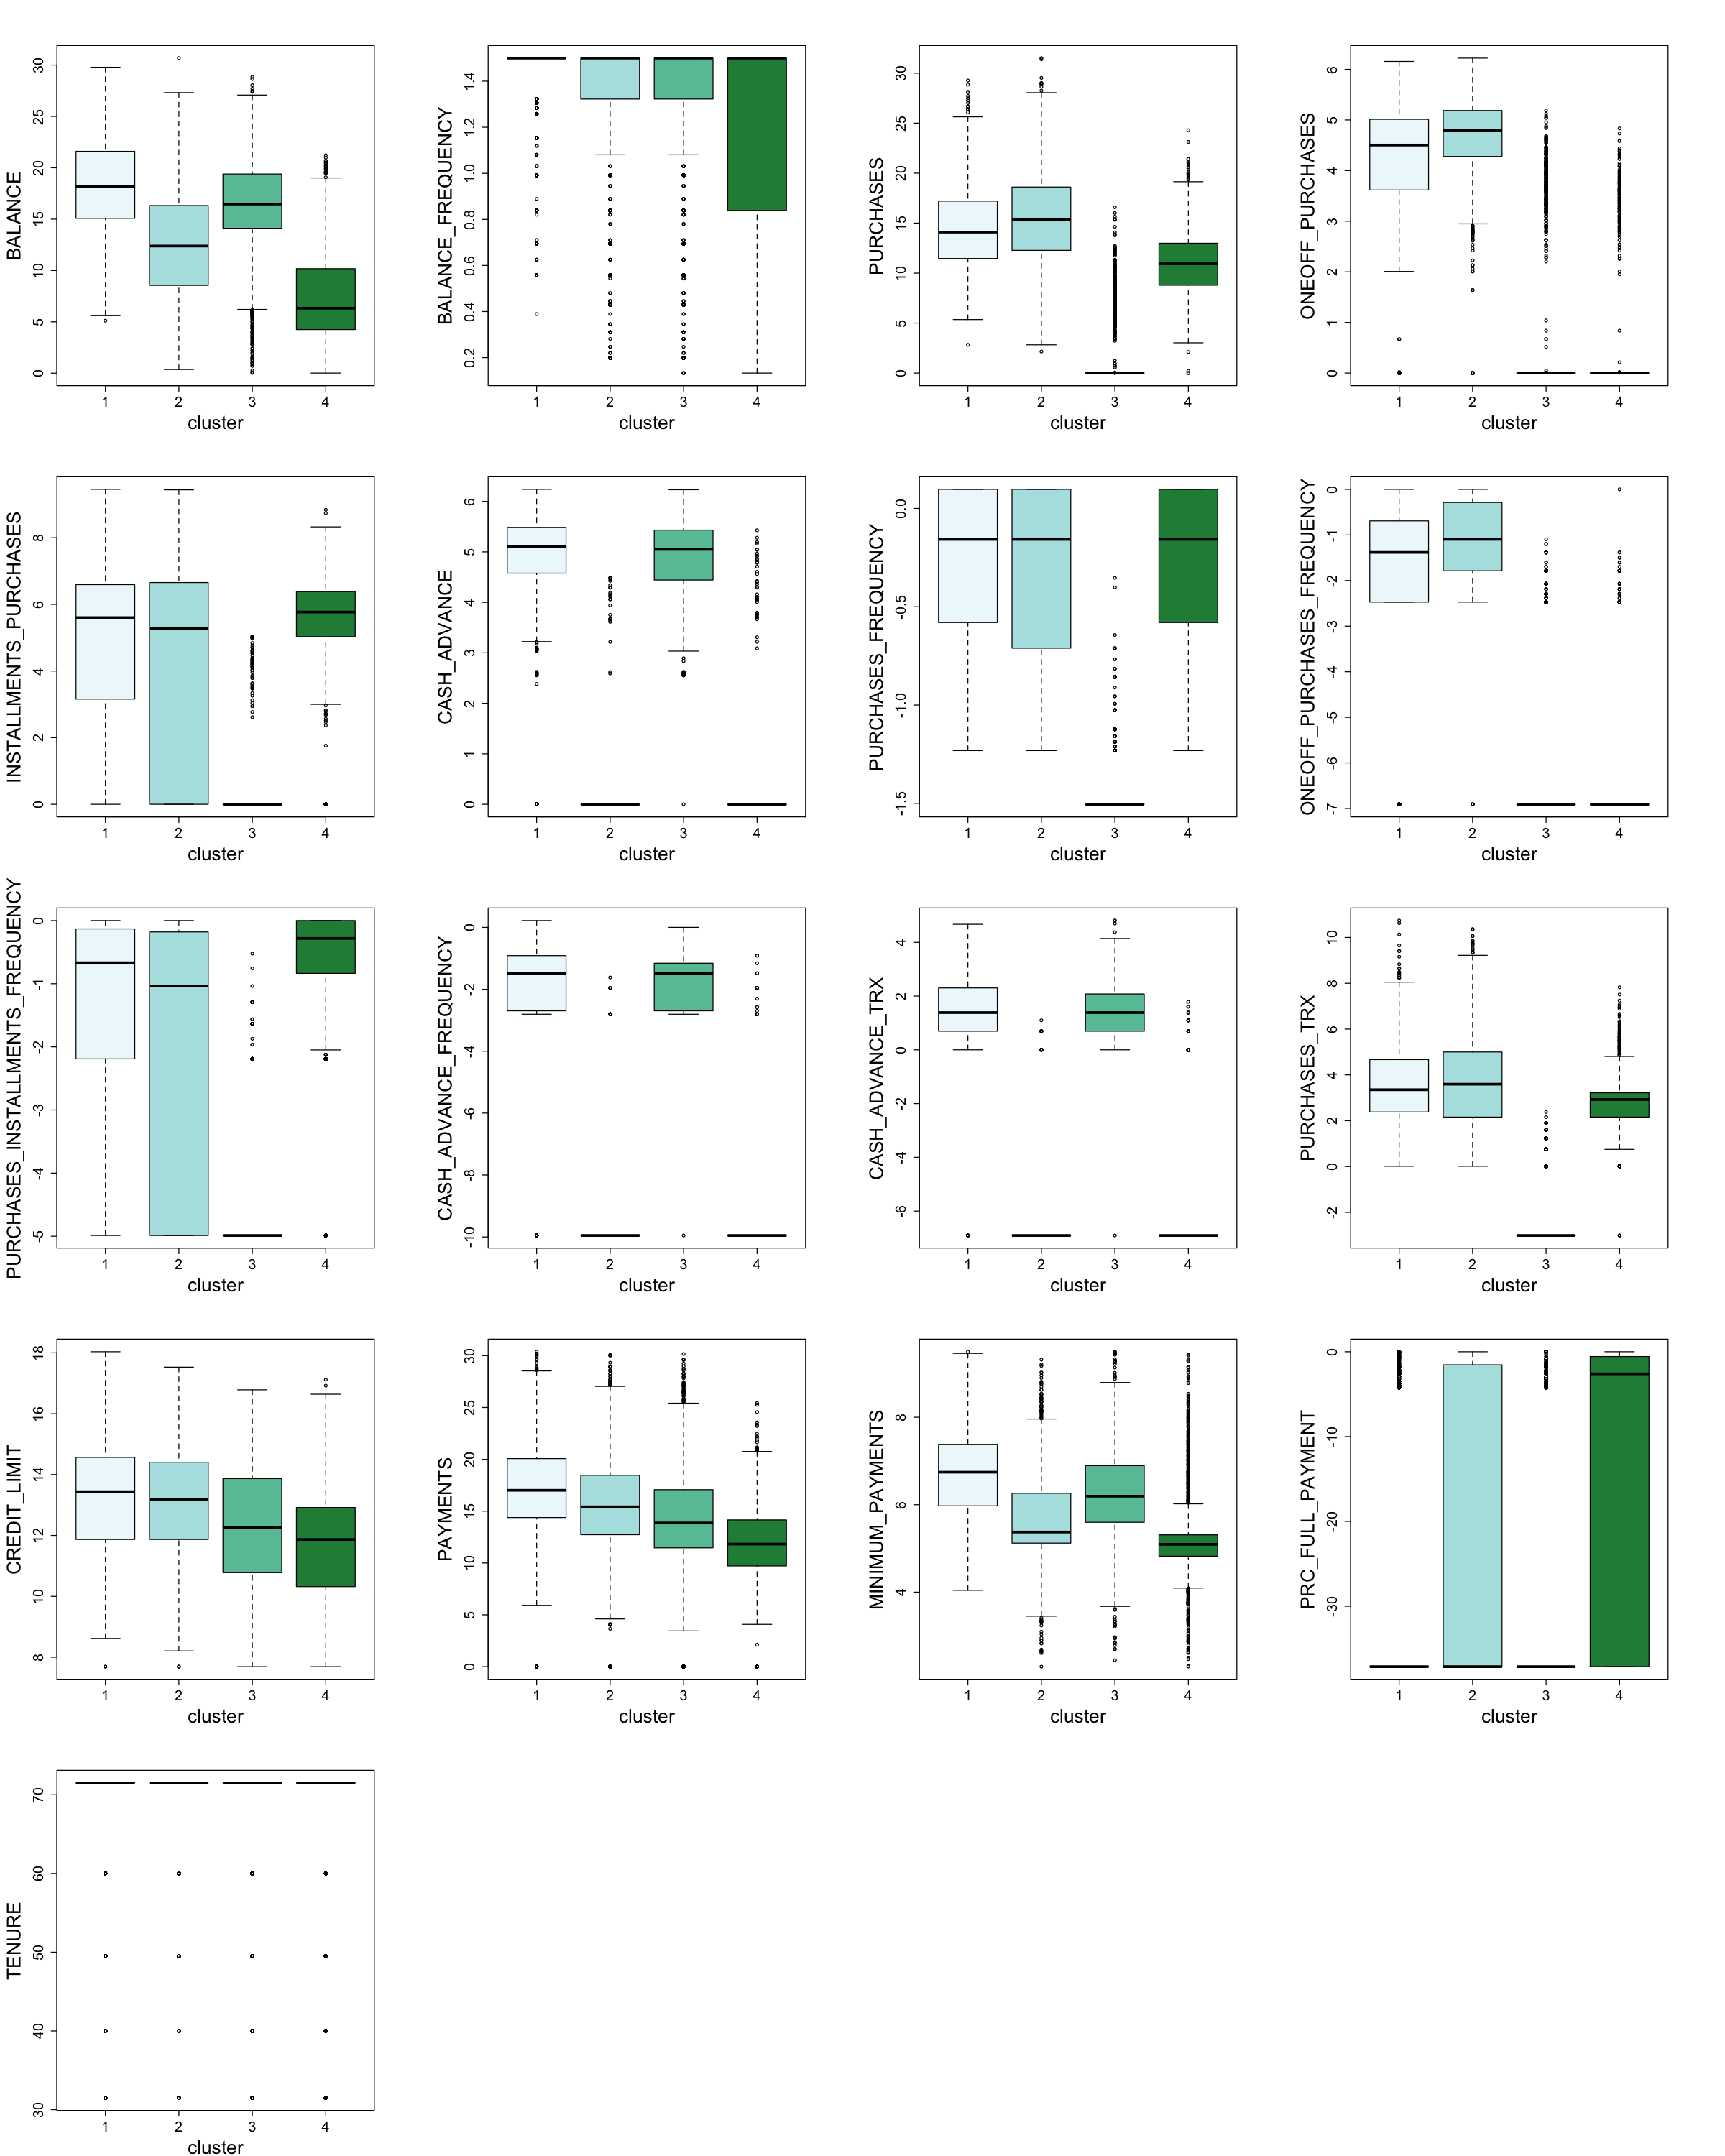

In [49]:
options(repr.plot.width=20, repr.plot.height=25)
par(mfrow=c(5,4), cex.lab=2, cex.axis=1.5, mar=c(4,5,4,5))

colors = brewer.pal(4, "BuGn")

for(name in names(df)) {
   boxplot(df_tidy[[name]]~df_tidy$cluster, xlab="cluster", col=colors, ylab=name)
}

Finally, we have represented the T-distributed Stochastic Neighbor Embedding (tSNE) for the obtained results considering 4 clusters as follows:

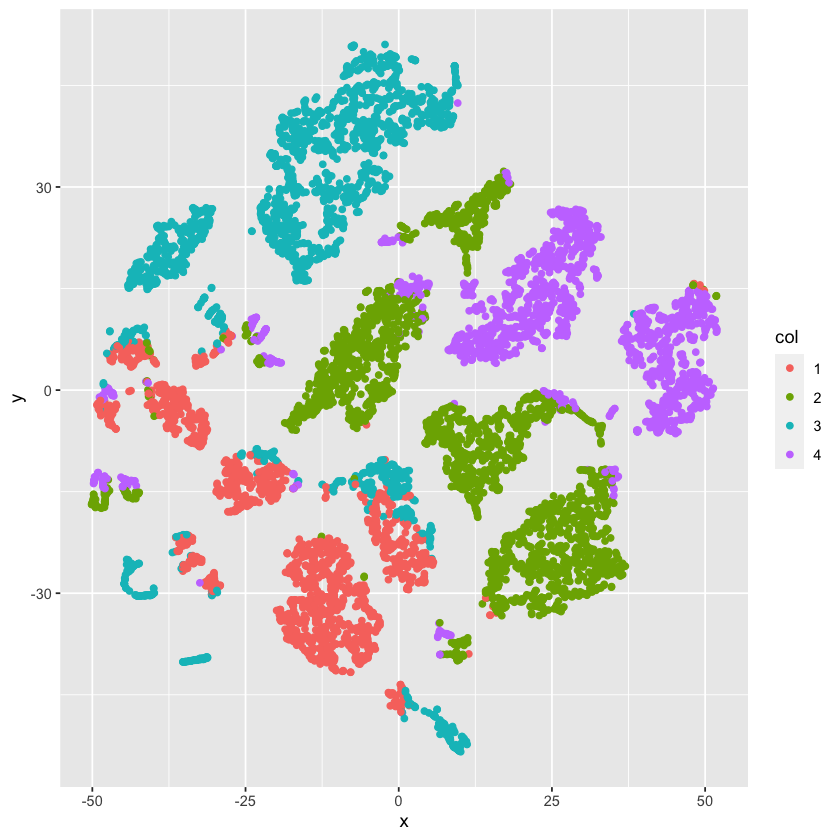

In [50]:
options(repr.plot.width=7, repr.plot.height=7)
tsne_out <- Rtsne(df_tidy)

tsne_plot <- data.frame(x = tsne_out$Y[,1], y = tsne_out$Y[,2], col = df_tidy$cluster)
 
ggplot(tsne_plot,label=df_tidy$cluster) + geom_point(aes(x = x, y = y, color = col))